In [1]:
##### timecorr comparision with random guess, true correlations and sliding window isfc
import numpy as np
from scipy.linalg import cholesky
from scipy.spatial.distance import squareform
from scipy.stats.stats import pearsonr
import timecorr
from math import log

sliding_window_length = 25
block_length = 1
covariance_num = 500
noise_level = 1

time_range=time_len = block_length * covariance_num
activation_num = 200
subject_num = 10
variance = 1000
activations = np.random.normal(0,1,[subject_num, activation_num, time_len])
correlations = np.zeros([covariance_num,activation_num,activation_num])
correlation1,correlation2 = np.zeros([activation_num,activation_num]), np.zeros([activation_num,activation_num])

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def cholesky_ramp_correlation_data():
    global activations, correlations,correlation1,correlation2
    correlations = np.zeros([covariance_num,activation_num,activation_num])
    activations_temp = np.random.normal(0,1,[activation_num, time_len])
    
    while not is_pos_def(correlation1):
        feature_map1 = np.random.normal(0,1,[activation_num,activation_num])
        correlation1 = np.dot(feature_map1,feature_map1.T)
        correlation1 = correlation1/np.max(abs(correlation1))
    while not is_pos_def(correlation2):
        feature_map2 = np.random.normal(0,1,[activation_num,activation_num])
        correlation2 = np.dot(feature_map2,feature_map2.T)
        correlation2 = correlation2/np.max(abs(correlation2))
    for i in range(time_len):
        cov_temp = (time_len-i)*0.5*(np.log(1+correlation1+1e-5) - np.log(1-correlation1+1e-5))/float(time_len)+i*0.5*(np.log(1+correlation2+1e-5) - np.log(1-correlation2+1e-5))/float(time_len)
        correlations[i] =  (np.exp(2*cov_temp) - 1)/(np.exp(2*cov_temp) + 1)
        activations_temp[:,i] = np.dot(cholesky(correlations[i]),activations_temp[:,i])
    activations=np.tile(activations_temp,[subject_num,1,1] )+np.random.normal(0,noise_level,[subject_num, activation_num, time_len])

        
timecorr_recovery = np.zeros([time_len,(activation_num * (activation_num-1) / 2)])
cholesky_ramp_correlation_data()

In [ ]:
import time
start = time.time()
repetitions=5
timing = np.zeros(repetitions)
for i in range(repetitions):
    timecorr_recovery = timecorr.isfc(activations)
    timing[i]= time.time()-start
    start = time.time()
print np.mean(timing), np.std(timing)

In [1]:
%%time
######## timecorr vs sliding window, different variances & ramp correlation
import sys
import os
sys.path.append(os.path.abspath('../timecorr/'))
from _shared.helpers import wcorr, sliding_window
import matplotlib.pyplot as plt
from math import log
import numpy as np
from scipy.linalg import cholesky
from scipy.spatial.distance import squareform
from scipy.stats.stats import pearsonr
variance = 1000
sliding_window_length = [11,25,51,101]
repetitions=100
length_num = len(sliding_window_length)

block_length = 1
covariance_num = 1000
time_len = block_length * covariance_num
activation_num = 20
activations = np.random.normal(0,10,[activation_num, time_len])
correlations = np.zeros([covariance_num,activation_num,activation_num])
correlation1,correlation2 = np.zeros([activation_num,activation_num]), np.zeros([activation_num,activation_num])

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def cholesky_ramp_correlation_data():
    global activations, correlations,correlation1,correlation2
    correlations = np.zeros([covariance_num,activation_num,activation_num])
    activations = np.random.normal(0,10,[activation_num, time_len])
    
    while not is_pos_def(correlation1):
        feature_map = np.random.normal(0,1,[activation_num,activation_num])
        correlation1 = 2*np.dot(feature_map,feature_map.T)-1
        correlation1 = correlation1/np.max(abs(correlation1))
    while not is_pos_def(correlation2):
        feature_map1 = np.random.normal(0,1,[activation_num,activation_num])
        correlation2 = 2*np.dot(feature_map1,feature_map1.T)-1
        correlation2 = correlation2/np.max(abs(correlation2))
    for i in range(time_len):
        cov_temp = (time_len-i)*0.5*(np.log(1+correlation1+1e-5) - np.log(1-correlation1+1e-5))/float(time_len)+i*0.5*(np.log(1+correlation2+1e-5) - np.log(1-correlation2+1e-5))/float(time_len)
        correlations[i] =  (np.exp(2*cov_temp) - 1)/(np.exp(2*cov_temp) + 1)
        activations[:,i] = np.dot(cholesky(correlations[i]),activations[:,i])

timecorr_recovery = np.zeros([time_len,(activation_num * (activation_num-1) / 2)])
cholesky_ramp_correlation_data()
for i in range(repetitions):
    timecorr_recovery = wcorr(activations,variance)
    

CPU times: user 1.9 s, sys: 1.57 s, total: 3.48 s
Wall time: 33.9 s


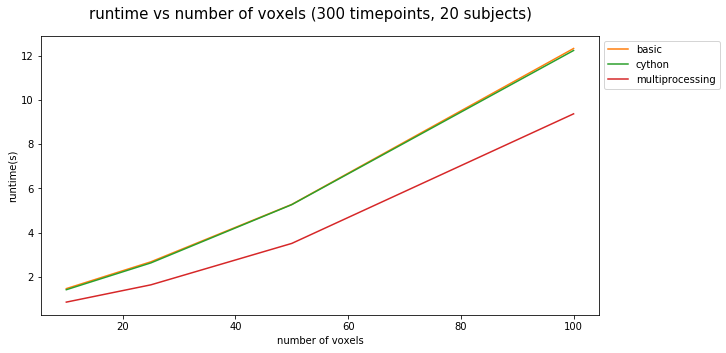

In [35]:
import matplotlib.pyplot as plt
f, a1 = plt.subplots(1,1, figsize=(10,5))
plt.subplots_adjust(top=0.9)
plt.suptitle("runtime vs number of voxels (300 timepoints, 20 subjects)",fontsize=15)
a1.set_ylabel("runtime(s)")
a1.set_xlabel("number of voxels")
x = [10,25,50,100]
basic = [1.48, 2.69, 5.28, 12.32]
cython = [1.43, 2.64, 5.27, 12.23]
multiprocessing = [0.87, 1.65, 3.52, 9.37]
# a1.bar(np.array(x),basic,5,color='C1',alpha=1,linestyle='-', label="basic")
# a1.bar(np.array(x)+5,cython,5,color='C2',alpha=1,linestyle='-', label="cython")
# a1.bar(np.array(x)+10,multiprocessing,5,color='C3',alpha=1,linestyle='-', label="multiprocessing")
a1.plot(np.array(x),basic,color='C1',alpha=1,linestyle='-', label="basic")
a1.plot(np.array(x),cython,color='C2',alpha=1,linestyle='-', label="cython")
a1.plot(np.array(x),multiprocessing,color='C3',alpha=1,linestyle='-', label="multiprocessing")

a1.legend(bbox_to_anchor=(1, 1), loc=0)
f.subplots_adjust(hspace=0.3)
plt.show()

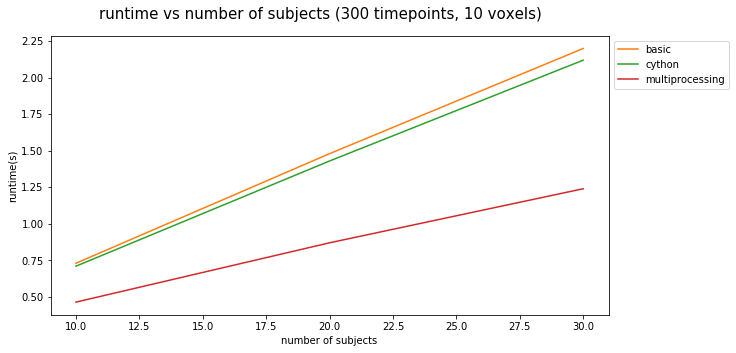

In [36]:
import matplotlib.pyplot as plt
f, a1 = plt.subplots(1,1, figsize=(10,5))
plt.subplots_adjust(top=0.9)
plt.suptitle("runtime vs number of subjects (300 timepoints, 10 voxels)",fontsize=15)
a1.set_ylabel("runtime(s)")
a1.set_xlabel("number of subjects")
x = [10,20,30]
basic = [0.73, 1.48, 2.2]
cython = [0.71, 1.43, 2.12]
multiprocessing = [0.464, 0.87, 1.24]
# a1.bar(np.array(x),basic,5,color='C1',alpha=1,linestyle='-', label="basic")
# a1.bar(np.array(x)+5,cython,5,color='C2',alpha=1,linestyle='-', label="cython")
# a1.bar(np.array(x)+10,multiprocessing,5,color='C3',alpha=1,linestyle='-', label="multiprocessing")
a1.plot(np.array(x),basic,color='C1',alpha=1,linestyle='-', label="basic")
a1.plot(np.array(x),cython,color='C2',alpha=1,linestyle='-', label="cython")
a1.plot(np.array(x),multiprocessing,color='C3',alpha=1,linestyle='-', label="multiprocessing")

a1.legend(bbox_to_anchor=(1, 1), loc=0)
f.subplots_adjust(hspace=0.3)
plt.show()

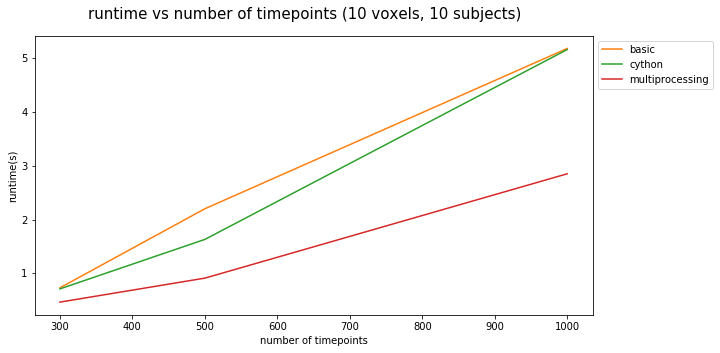

In [38]:
import matplotlib.pyplot as plt
f, a1 = plt.subplots(1,1, figsize=(10,5))
plt.subplots_adjust(top=0.9)
plt.suptitle("runtime vs number of timepoints (10 voxels, 10 subjects)",fontsize=15)
a1.set_ylabel("runtime(s)")
a1.set_xlabel("number of timepoints")
x = [300,500,1000]
basic = [0.73, 2.2, 5.18]
cython = [0.71, 1.63, 5.16]
multiprocessing = [0.464, 0.91, 2.85]
# a1.bar(np.array(x),basic,5,color='C1',alpha=1,linestyle='-', label="basic")
# a1.bar(np.array(x)+5,cython,5,color='C2',alpha=1,linestyle='-', label="cython")
# a1.bar(np.array(x)+10,multiprocessing,5,color='C3',alpha=1,linestyle='-', label="multiprocessing")
a1.plot(np.array(x),basic,color='C1',alpha=1,linestyle='-', label="basic")
a1.plot(np.array(x),cython,color='C2',alpha=1,linestyle='-', label="cython")
a1.plot(np.array(x),multiprocessing,color='C3',alpha=1,linestyle='-', label="multiprocessing")

a1.legend(bbox_to_anchor=(1, 1), loc=0)
f.subplots_adjust(hspace=0.3)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
f, a1 = plt.subplots(1,1, figsize=(10,5))
plt.subplots_adjust(top=0.9)
plt.suptitle("runtime vs number of timepoints (10 voxels, 10 subjects)",fontsize=15)
a1.set_ylabel("runtime(s)")
a1.set_xlabel("number of timepoints")
x = [300,500,1000]
basic = [0.73, 2.2, 5.18]
cython = [0.71, 1.63, 5.16]
multiprocessing = [0.464, 0.91, 2.85]
# a1.bar(np.array(x),basic,5,color='C1',alpha=1,linestyle='-', label="basic")
# a1.bar(np.array(x)+5,cython,5,color='C2',alpha=1,linestyle='-', label="cython")
# a1.bar(np.array(x)+10,multiprocessing,5,color='C3',alpha=1,linestyle='-', label="multiprocessing")
a1.plot(np.array(x),basic,color='C1',alpha=1,linestyle='-', label="basic")
a1.plot(np.array(x),cython,color='C2',alpha=1,linestyle='-', label="cython")
a1.plot(np.array(x),multiprocessing,color='C3',alpha=1,linestyle='-', label="multiprocessing")

a1.legend(bbox_to_anchor=(1, 1), loc=0)
f.subplots_adjust(hspace=0.3)
plt.show()

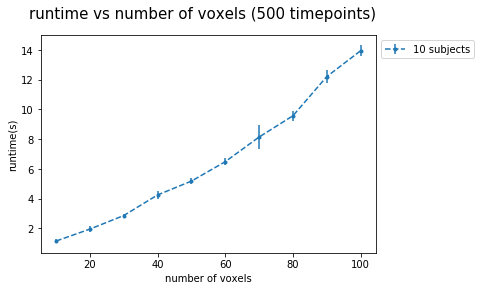

In [43]:
import matplotlib.pyplot as plt
plt.suptitle("runtime vs number of voxels (500 timepoints)",fontsize=15)
plt.ylabel("runtime(s)")
plt.xlabel("number of voxels")
# x = [10,20,30,40,50,60,70,80,90,100]
# y = [9.493814278,16.07424006,24.98841758,34.58439751,45.51494713,63.72520857,106.8594588,171.8149325,355.1380524,573.6368614]
# yerr = [0.495152307,0.177473937,0.73498378,0.320587984,0.36111853,3.129638227,4.709304053,7.874586894,18.49332249,16.44951014]
# plt.errorbar(x, y, yerr=yerr, fmt='--.', label = "100 subjects")
# y = [5.311187625,8.980884552,13.43328269,18.68696117,25.07034452,30.9554616,38.13003552,48.26257839,68.62977917,104.3838875]
# yerr = [0.343960905,0.29417726,0.286855005,0.483366984,2.052174631,1.088746935,0.530414867,2.878595701,2.880773231,3.195101171]
# plt.errorbar(x, y, yerr=yerr, fmt='--.', label = "50 subjects")
y = [1.153998232,1.95816195,2.869322872,4.254905581,5.182921243,6.488357949,8.147046185,9.574489665,12.2077136,13.94614828]
yerr = [0.128286787,0.181291096,0.120109649,0.273749668,0.210933671,0.251502113,0.82249324,0.322304212,0.4204737,0.374899879]
plt.errorbar(x, y, yerr=yerr, fmt='--.', label = "10 subjects")
plt.legend(bbox_to_anchor=(1, 1), loc=0)
plt.show()